In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore 
from scipy.sparse.linalg import eigsh

from skimage.measure import block_reduce
from sklearn.cluster import KMeans


import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures
import os

In [28]:
final_mask = np.load(r"/home/k21208334/calcium_analyses/data/dowsampled_tight_mask.npy")
good_indices = np.ravel(final_mask)

h=300
w=304
H = 50
W = 51


window_size = 30
# n_comp = 10 #number of ICA components
n_comp = 20

names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]


path = '/home/k21208334/calcium_analyses/data/leading_eigenvectors/window_size=' + str(window_size) + '/'


# characterization of LEiDA signal

In [82]:
#plot speed of 1 mouse for example
eigenvalues_all = np.load(path+names[0]+'_eigenvalue_timeseries.npy')

for name in names[1:]+names_knock:
    position = np.load(path+name+'_eigenvalue_timeseries.npy')
    eigenvalues_all = np.vstack((eigenvalues_all,position))

In [83]:
eigenvalues_all.shape

(300000, 1)

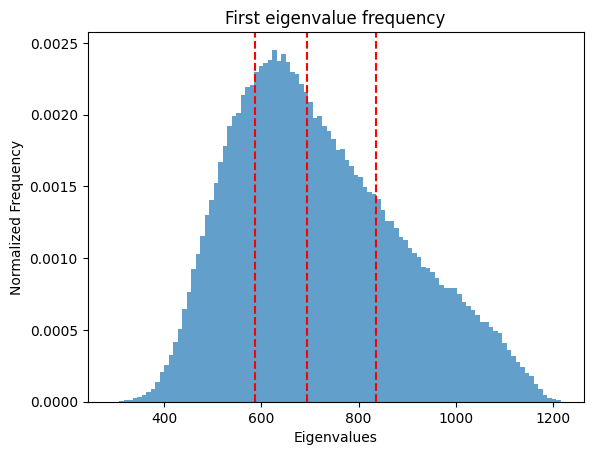

In [86]:
# Calculate percentiles
percentiles = [25, 50, 75]  # You can adjust the percentiles as needed
percentile_values = np.percentile(eigenvalues_all, percentiles)

# Plot normalized histogram
plt.hist(eigenvalues_all, bins=100, density=True, alpha=0.7)

# Plot vertical lines for percentiles
for percentile in percentile_values:
    plt.axvline(x=percentile, color='r', linestyle='--')

# Add labels and title
plt.xlabel('Eigenvalues')
plt.ylabel('Normalized Frequency')
plt.title('First eigenvalue frequency')

# Display the plot
plt.show()


In [90]:
np.sum(eigenvalues_all>629)/300000

0.64886

In [62]:

# load clustered data 

for name in names+names_knock:

    data = path + name + ".npy"
    centr = np.load(data)
    eigenvectors_all = np.vstack((eigenvectors_all,centr))

(25000,)

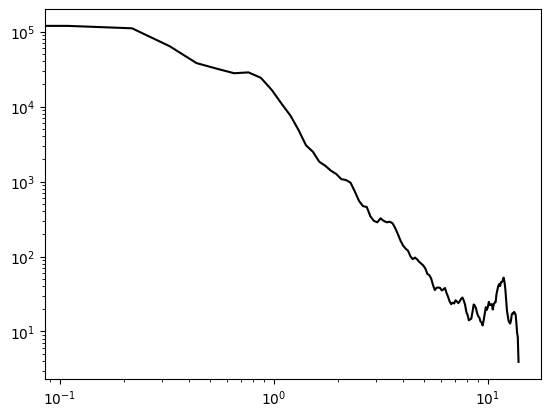

In [30]:
# spectral properties of 1st eigenvector
from scipy import signal
Ts = 0.036
(f, S) = signal.welch(position, 1/Ts, scaling='density') # you can also try signal.periodogram

fig,ax = plt.subplots()
ax.loglog(f,S,color="black")

In [35]:
eigenvectors_all = np.empty((0,np.sum(final_mask))) # to change this!!!!!

# load clustered data 

for name in names[0:1]:

    data = path + name + ".npy"
    centr = np.load(data)
    eigenvectors_all = np.vstack((eigenvectors_all,centr))

In [40]:
start,end = 0,2000

for name in names[0:1]:

    base_directory = r"/home/k21208334/calcium_analyses/data/" + name + "/"
    registered_directory = r"/home/k21208334/calcium_analyses/data/registration_data/" + name + "/"
    sample = widefield_utils.load_registered_sample(base_directory,registered_directory,start,end)
    coarse_sample = block_reduce(sample, block_size=(6,6,1), func=np.mean) 
    all_signals = np.reshape(coarse_sample,(H*W,end))
    signals = all_signals[good_indices,:]
    signals=signals.T

In [47]:
# correlate leida signal with raw data 

eigenvectors_all = eigenvectors_all[0:end,:]

correl_leida_raw = np.zeros(np.sum(good_indices))

for i in range(np.sum(good_indices)):
    correl_leida_raw[i] = np.corrcoef(signals[:,i],eigenvectors_all[:,i])[0,1]
    

0.11362885593717337

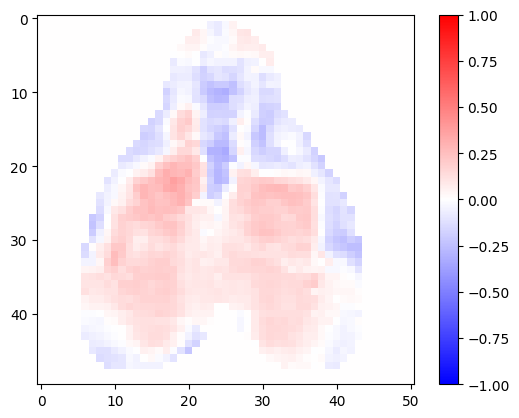

In [91]:
# show it 
connectivity_measures.show_array(correl_leida_raw,H,W,good_indices,(-1,1))
np.mean(np.abs(correl_leida_raw))

(array([ 1.,  1.,  0.,  1.,  1.,  2.,  4.,  2.,  3.,  2.,  1.,  5.,  3.,
         5.,  2.,  4.,  5.,  3.,  8., 10.,  7.,  6.,  9., 14., 13.,  6.,
        10., 13., 14., 18., 18.,  9., 12., 19., 12., 11., 15.,  9., 15.,
        27., 23., 15., 29., 20., 19., 19., 20., 19., 20., 12., 22., 18.,
        21., 20., 26., 22., 26., 23., 28., 24., 24., 28., 27., 34., 28.,
        38., 25., 36., 30., 25., 28., 23., 17., 20., 17., 10., 16., 10.,
         6., 11.,  8.,  6., 10.,  9.,  4.,  3.,  3.,  3.,  3.,  1.,  1.,
         3.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([-3.28128336e-01, -3.21153158e-01, -3.14177981e-01, -3.07202803e-01,
        -3.00227625e-01, -2.93252448e-01, -2.86277270e-01, -2.79302092e-01,
        -2.72326915e-01, -2.65351737e-01, -2.58376559e-01, -2.51401382e-01,
        -2.44426204e-01, -2.37451026e-01, -2.30475849e-01, -2.23500671e-01,
        -2.16525493e-01, -2.09550316e-01, -2.02575138e-01, -1.95599960e-01,
        -1.88624783e-01, -1.81649605e-01, -1.74674427e

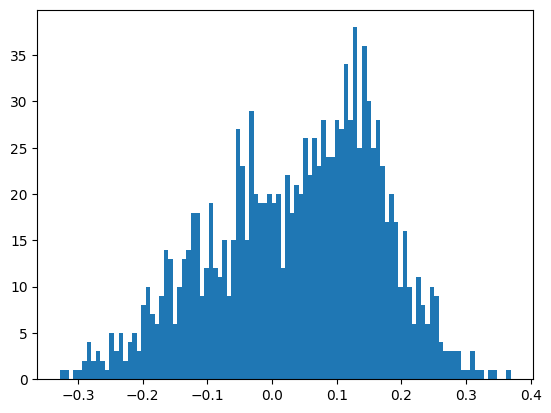

In [55]:
#do histogram to see how much this is corr
# TAKE HOME MESSAGE: THERE IS MUCH MORE INFORMATION!

plt.hist(correl_leida_raw,bins=100)

# analyze properties of the eigenvalue: how much variance is explained; irreducibility index

In [42]:
np.sum(good_indices)

1258

In [11]:
# let's define speed. 

n_individuals = len(names+names_knock)
reconf_speed_walk = np.zeros((n_individuals))
reconf_speed_rest = np.zeros((n_individuals))
speed_variance_walk = np.zeros((n_individuals))
speed_variance_rest = np.zeros((n_individuals))

for i,name in enumerate(names+names_knock):
    walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
    reconf_speed = np.load(path+name+'_reconf_speed.npy')
    reconf_speed_walk[i] = np.mean(reconf_speed[walking])
    reconf_speed_rest[i] = np.mean(reconf_speed[~walking])
    speed_variance_walk[i] = np.var(reconf_speed[walking])
    speed_variance_rest[i] = np.var(reconf_speed[~walking])

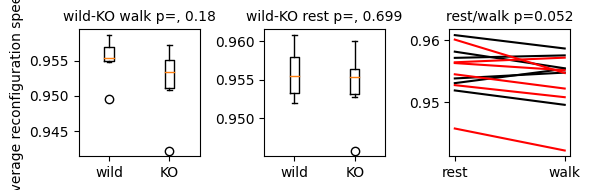

In [14]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

fig,ax = plt.subplots(1,3)
fig.set_size_inches(6,2)

ax[0].boxplot([reconf_speed_walk[0:6],reconf_speed_walk[6:12]])
test = mannwhitneyu(reconf_speed_walk[0:6],reconf_speed_walk[6:12])
pvalue = test.pvalue
ax[0].set_title('wild-KO walk p=, '+str(round(pvalue,3)),fontsize=10)
ax[0].set_xticks([1,2], ['wild','KO'])
ax[0].set_ylabel('average reconfiguration speed')
    
ax[1].boxplot([reconf_speed_rest[0:6],reconf_speed_rest[6:12]])
test = mannwhitneyu(reconf_speed_rest[0:6],reconf_speed_rest[6:12])
pvalue = test.pvalue
ax[1].set_title('wild-KO rest p=, '+str(round(pvalue,3)),fontsize=10)
ax[1].set_xticks([1,2], ['wild','KO'])
    
# try also statistics on walk vs non walk as a control...
ax[2].plot([reconf_speed_rest[0:6],reconf_speed_walk[0:6]],color='black')
ax[2].plot([reconf_speed_rest[6:12],reconf_speed_walk[6:12]],color='red')
test = wilcoxon(reconf_speed_rest,reconf_speed_walk)
pvalue = test.pvalue
ax[2].set_title('rest/walk p='+str(round(pvalue,3)),fontsize=10)
ax[2].set_xticks([0,1], ['rest','walk'])
fig.tight_layout()

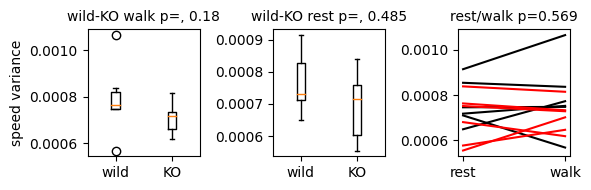

In [16]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(6,2)

ax[0].boxplot([speed_variance_walk[0:6],speed_variance_walk[6:12]])
test = mannwhitneyu(speed_variance_walk[0:6],speed_variance_walk[6:12])
pvalue = test.pvalue
ax[0].set_title('wild-KO walk p=, '+str(round(pvalue,3)),fontsize=10)
ax[0].set_xticks([1,2], ['wild','KO'])
ax[0].set_ylabel('speed variance')
    
ax[1].boxplot([speed_variance_rest[0:6],speed_variance_rest[6:12]])
test = mannwhitneyu(speed_variance_rest[0:6],speed_variance_rest[6:12])
pvalue = test.pvalue
ax[1].set_title('wild-KO rest p=, '+str(round(pvalue,3)),fontsize=10)
ax[1].set_xticks([1,2], ['wild','KO'])
    
# try also statistics on walk vs non walk as a control...
ax[2].plot([speed_variance_rest[0:6],speed_variance_walk[0:6]],color='black')
ax[2].plot([speed_variance_rest[6:12],speed_variance_walk[6:12]],color='red')
test = wilcoxon(speed_variance_rest,speed_variance_walk)
pvalue = test.pvalue
ax[2].set_title('rest/walk p='+str(round(pvalue,3)),fontsize=10)
ax[2].set_xticks([0,1], ['rest','walk'])
fig.tight_layout()

In [17]:
# let's define eigenvalue measures. 

n_individuals = len(names+names_knock)
avg_eigenvalue_walk = np.zeros((n_individuals))
avg_eigenvalue_rest = np.zeros((n_individuals))
metastability_walk = np.zeros((n_individuals))
metastability_rest = np.zeros((n_individuals))

for i,name in enumerate(names+names_knock):
    walking = np.load('/home/k21208334/calcium_analyses/data/walking/'+name+'.npy')
    timeseries = np.load(path+name+'_eigenvalue_timeseries.npy')
    avg_eigenvalue_walk[i] = np.mean(timeseries[walking])
    avg_eigenvalue_rest[i] = np.mean(timeseries[~walking])
    metastability_walk[i] = np.var(timeseries[walking])
    metastability_rest[i] = np.var(timeseries[~walking])

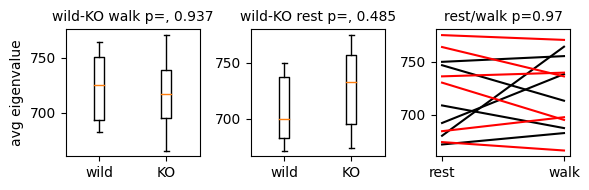

In [18]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(6,2)

ax[0].boxplot([avg_eigenvalue_walk[0:6],avg_eigenvalue_walk[6:12]])
test = mannwhitneyu(avg_eigenvalue_walk[0:6],avg_eigenvalue_walk[6:12])
pvalue = test.pvalue
ax[0].set_title('wild-KO walk p=, '+str(round(pvalue,3)),fontsize=10)
ax[0].set_xticks([1,2], ['wild','KO'])
ax[0].set_ylabel('avg eigenvalue')
    
ax[1].boxplot([avg_eigenvalue_rest[0:6],avg_eigenvalue_rest[6:12]])
test = mannwhitneyu(avg_eigenvalue_rest[0:6],avg_eigenvalue_rest[6:12])
pvalue = test.pvalue
ax[1].set_title('wild-KO rest p=, '+str(round(pvalue,3)),fontsize=10)
ax[1].set_xticks([1,2], ['wild','KO'])
    
# try also statistics on walk vs non walk as a control...
ax[2].plot([avg_eigenvalue_rest[0:6],avg_eigenvalue_walk[0:6]],color='black')
ax[2].plot([avg_eigenvalue_rest[6:12],avg_eigenvalue_walk[6:12]],color='red')
test = wilcoxon(avg_eigenvalue_rest,avg_eigenvalue_walk)
pvalue = test.pvalue
ax[2].set_title('rest/walk p='+str(round(pvalue,3)),fontsize=10)
ax[2].set_xticks([0,1], ['rest','walk'])
fig.tight_layout()

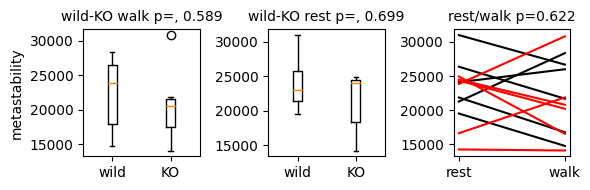

In [19]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(6,2)

ax[0].boxplot([metastability_walk[0:6],metastability_walk[6:12]])
test = mannwhitneyu(metastability_walk[0:6],metastability_walk[6:12])
pvalue = test.pvalue
ax[0].set_title('wild-KO walk p=, '+str(round(pvalue,3)),fontsize=10)
ax[0].set_xticks([1,2], ['wild','KO'])
ax[0].set_ylabel('metastability')
    
ax[1].boxplot([metastability_rest[0:6],metastability_rest[6:12]])
test = mannwhitneyu(metastability_rest[0:6],metastability_rest[6:12])
pvalue = test.pvalue
ax[1].set_title('wild-KO rest p=, '+str(round(pvalue,3)),fontsize=10)
ax[1].set_xticks([1,2], ['wild','KO'])
    
# try also statistics on walk vs non walk as a control...
ax[2].plot([metastability_rest[0:6],metastability_walk[0:6]],color='black')
ax[2].plot([metastability_rest[6:12],metastability_walk[6:12]],color='red')
test = wilcoxon(metastability_rest,metastability_walk)
pvalue = test.pvalue
ax[2].set_title('rest/walk p='+str(round(pvalue,3)),fontsize=10)
ax[2].set_xticks([0,1], ['rest','walk'])
fig.tight_layout()